In [1]:
import cv2,os,torch
import json
import matplotlib.pyplot as plt
import numpy as np
from load_data import load_data
from torch.utils.data import Dataset,DataLoader
import albumentations as albu
import torchvision
import torch.nn as nn
import sys
sys.path.append('/home/chenyixin/chenyixin/')
import segmentor

Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


In [2]:
def load_data(path='./data',mode='train',verbose=False):
    types_dict = {'/恶性/':'malign', '/良性/':'benign', '/交界性/':'borderline'}
    imgs,masks_pa,masks_tu,type_labels = [],[],[],[]
    name = []
    
    for basepath,dirnames,files in os.walk(path):
        jpg = [f for f in files if '.jpg' in f]
        if len(jpg) == 0:
            continue
        for j in jpg:
            jpg_path = os.path.join(basepath,j)
            img = cv2.imread(jpg_path)

            try:
                js = json.load(open(jpg_path.replace('.jpg','.json'),'r'))
            except:
                print(jpg_path)
                break
            if len(img.shape)==2:    
                mask = np.zeros_like(img)
            elif len(img.shape) ==3:
                mask_pa = np.zeros_like(img[:,:,0])
                mask_tu = np.zeros_like(img[:,:,0])
            for shape in js['shapes']:
                if shape['label']== "papillary":
                    cv2.fillPoly(mask_pa,[np.int32(shape['points'])],color=255)
                if shape['label']== "tumor":
                    cv2.fillPoly(mask_tu,[np.int32(shape['points'])],color=255)
            for t in types_dict:
                if t in basepath:
                    break
            na = basepath.replace("/Image","").split("/")[-1]
            
            if np.max(mask_tu)==0:
                continue
            imgs.append(img)
            masks_pa.append(mask_pa)
            masks_tu.append(mask_tu)
            type_labels.append(types_dict[t])
            name.append(na)
                
    return imgs,masks_pa,masks_tu,type_labels,name

In [3]:
imgs,masks_pa,masks_tu,type_labels,name = load_data(path='./AI基线资料乳头/灰色/',verbose=False)
c_imgs,c_masks_pa,c_masks_tu,c_type_labels,c_name = load_data(path='./AI基线资料乳头/彩色/',verbose=False)

./AI基线资料乳头/灰色/良性/生殖/杨囡_02.201709121224.01成熟性畸胎瘤/Images/02.201709121224.01.0013.1505201809.jpg
./AI基线资料乳头/灰色/良性/巧囊/柴春蕾_02.201612190406.01巧囊/Images/02.201612190406.01.0004.1482111408.jpg
./AI基线资料乳头/彩色/恶性/原发卵巢癌/蒋秀丽_02.202112110297.01高级别浆液性癌/Images/02.202112110297.01.20188.0007.10583900218.jpg
./AI基线资料乳头/彩色/恶性/转移癌/温镝飞_02.201906110907.01平滑肌瘤卵巢种植转移瘤C/Images/02.201906110907.01.0005.11215400612.jpg
./AI基线资料乳头/彩色/良性/性索间质/胡桂桃_02.201804090182.01梭形细胞瘤即卵泡膜细胞瘤C/Images/02.201804090182.01.0012.1523234956.jpg
./AI基线资料乳头/彩色/良性/性索间质/彭文红_02.201908221713.02卵泡膜纤维瘤伴水肿C/Images/02.201908221713.02.21288.0006.14394100671.jpg
./AI基线资料乳头/彩色/良性/性索间质/白丽_02.201904110646.01纤维卵泡膜细胞瘤C/Images/02.201904110646.01.0005.09061200428.jpg
./AI基线资料乳头/彩色/良性/其它上皮/吕艳文_02.201907300832.01黏液性囊腺瘤C/Images/02.201907300832.01.21288.0010.09130600910.jpg
./AI基线资料乳头/彩色/良性/其它上皮/崔爱成_02.201911140653.01黏液囊腺瘤伴灶状钙化C/Images/02.201911140653.01.21296.0010.08594100187.jpg
./AI基线资料乳头/彩色/良性/其它上皮/佟秀清_02.201910220521.02浆液性囊腺瘤C/Images/02.201910220521.02.21

In [4]:
imgs = imgs + c_imgs
masks_pa = masks_pa + c_masks_pa
masks_tu = masks_tu + c_masks_tu
type_labels = type_labels + c_type_labels
name = name + c_name

In [5]:
test = ['2020','2021',"2019"]
tr_imgs,tr_masks_pa,tr_masks_tu,tr_type_labels,tr_name = [],[],[],[],[]
te_imgs,te_masks_pa,te_masks_tu,te_type_labels,te_name = [],[],[],[],[]
for i in range(len(name)):
    istest = False
    for t in test:
        if f'.{t}' in name[i]:
            istest = True
    if istest:
        te_imgs.append(imgs[i])
        te_masks_pa.append(masks_pa[i])
        te_masks_tu.append(masks_tu[i])
        te_type_labels.append(type_labels[i])
        te_name.append(name[i])
    else:
        if np.max(masks_pa[i]) != 0:
            for ii in range(5):
                tr_imgs.append(imgs[i])
                tr_masks_pa.append(masks_pa[i])
                tr_masks_tu.append(masks_tu[i])
                tr_type_labels.append(type_labels[i])
                tr_name.append(name[i])
        else:
            tr_imgs.append(imgs[i])
            tr_masks_pa.append(masks_pa[i])
            tr_masks_tu.append(masks_tu[i])
            tr_type_labels.append(type_labels[i])
            tr_name.append(name[i])

In [6]:
## combine
def extract_name(n):
    n = n.split('_')
    n1,n2 = n[0],n[1]
    n1 += '_'
    for n22 in n2:
        if not (n22.isdigit() or n22 in ['.','C'] ):
            n1 += n22
    return n1
train_case,test_case = {},{}

for i,n in enumerate(tr_name):
    n1 = extract_name(n)
    if not train_case.__contains__(n1):
        train_case[n1] = tr_type_labels[i]
for i,n in enumerate(te_name):
    n1 = extract_name(n)
    if not test_case.__contains__(n1):
        test_case[n1] = te_type_labels[i]
def statistic(case):
    sta = {}
    for key in case:
        gray = case[key]
        if not sta.__contains__(gray):
            sta[gray] = 1
        else:
            sta[gray] += 1
    print(sta)
statistic(train_case)
statistic(test_case)

{'malign': 167, 'benign': 374, 'borderline': 50}
{'malign': 56, 'benign': 134, 'borderline': 15}


In [7]:
n = 0
nn = 0
for i,m_pa,m_tu in zip(tr_imgs,tr_masks_pa,tr_masks_tu):
    
    if np.max(m_pa)==0:
        n += 1
    else:
        nn += 1
n,nn

(1667, 1185)

In [8]:
class mydataset(Dataset):
    def __init__(self,imgs,masks_pa,masks_tu,types_labels,name,croptumour=False,mode='train'):
        self.imgs = imgs
        self.masks_pa = masks_pa
        self.masks_tu = masks_tu
        self.tlabels = types_labels
        self.type_dict = {'benign':0,'borderline':1,'malign':2}
        
        if croptumour:
            self.trans = albu.Compose([
                albu.OneOf([
                    albu.Resize(height=224,width=224),
                    albu.Compose([
                        albu.Resize(height=280,width=280),
                        albu.RandomCrop(height=224,width=224)
                    ])
                ],p=1),
                albu.ShiftScaleRotate(p=0.5),
                albu.HorizontalFlip(p=0.2),
                albu.VerticalFlip(p=0.2),
            ])
            self.valtrans = albu.Compose([
                albu.Resize(height=224,width=224),
            ])
        else:
            self.trans = albu.Compose([
                albu.OneOf([
                    albu.Resize(height=320,width=480),
                    albu.Compose([
                        albu.Resize(height=360,width=520),
                        albu.RandomCrop(height=320,width=480)
                    ])
                ],p=1),
                albu.ShiftScaleRotate(p=0.5),
                albu.HorizontalFlip(p=0.2),
                albu.VerticalFlip(p=0.2),
            ])
            self.valtrans = albu.Compose([
                albu.Resize(height=320,width=480),
            ])
        self.croptumour = croptumour
        self.mode = mode
        self.name = name
        
    def __getitem__(self,index):
        
        img = self.imgs[index]
        mask_pa = self.masks_pa[index]
        mask_tu = self.masks_tu[index]
        mask_pa[mask_pa!=0] = 1
        mask_tu[mask_tu!=0] = 1
        
        if not self.croptumour:
            if self.mode=='train':
                trans = self.trans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']
            else:
                trans = self.valtrans(image=img,mask=mask)
                img,mask = trans['image'],trans['mask']

            tlabel = self.type_dict[self.tlabels[index]]
            
            if len(img.shape) == 2:
                img = torch.tensor(img/255).float().unsqueeze(0)
            elif len(img.shape) == 3:
                img = torch.tensor(img/255).float().permute(2,0,1)
            mask = torch.tensor(mask).long()
            tlabel = torch.tensor(tlabel).long()
            return img,mask,tlabel,self.name[index]
        else:
            img = self.cutedge(img,mask_tu)
            mask_pa = self.cutedge(mask_pa,mask_tu)
            if self.mode == 'train':
                trans = self.trans(image=img,mask=mask_pa)
                img,mask_pa = trans["image"],trans["mask"]
            else:
                trans = self.valtrans(image=img,mask=mask_pa)
                img,mask_pa = trans["image"],trans["mask"]
            tlabel = self.type_dict[self.tlabels[index]]
            if len(img.shape) == 2:
                img = torch.tensor(img/255).float().unsqueeze(0)
            elif len(img.shape) == 3:
                img = torch.tensor(img/255).float().permute(2,0,1)
            tlabel = torch.tensor(tlabel).long()
            mask_pa = torch.tensor(mask_pa).long()
            return img,mask_pa,tlabel,self.name[index]
    def __len__(self):
        return len(self.imgs)
    
    def cutedge(self,img,mask):
        tmp1 = np.max(mask,axis=0)
        tmp2 = np.max(mask,axis=1)
        for a,t in enumerate(tmp1):
            if t != 0:
                break
        for b,t in enumerate(tmp1[::-1]):
            if t != 0:
                break
        for c,t in enumerate(tmp2):
            if t != 0:
                break
        for d,t in enumerate(tmp2[::-1]):
            if t != 0:
                break
        img = img[c:len(tmp2)-d,a:len(tmp1)-b]
        return img

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def one_hot(label, n_classes, requires_grad=True):
    """Return One Hot Label"""
    divce = label.device
    one_hot_label = torch.eye(
        n_classes, device=device, requires_grad=requires_grad)[label]
    one_hot_label = one_hot_label.transpose(1, 3).transpose(2, 3)

    return one_hot_label


class BoundaryLoss(nn.Module):
    """Boundary Loss proposed in:
    Alexey Bokhovkin et al., Boundary Loss for Remote Sensing Imagery Semantic Segmentation
    https://arxiv.org/abs/1905.07852
    """

    def __init__(self, theta0=3, theta=5):
        super().__init__()

        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred, gt):
        """
        Input:
            - pred: the output from model (before softmax)
                    shape (N, C, H, W)
            - gt: ground truth map
                    shape (N, H, w)
        Return:
            - boundary loss, averaged over mini-bathc
        """

        n, c, _, _ = pred.shape

        # softmax so that predicted map can be distributed in [0, 1]
        pred = torch.softmax(pred, dim=1)

        # one-hot vector of ground truth
        one_hot_gt = one_hot(gt, c)
        # boundary map
        gt_b = F.max_pool2d(
            1 - one_hot_gt, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        gt_b -= 1 - one_hot_gt

        pred_b = F.max_pool2d(
            1 - pred, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        pred_b -= 1 - pred

        # extended boundary map
        gt_b_ext = F.max_pool2d(
            gt_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        pred_b_ext = F.max_pool2d(
            pred_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        # reshape
        gt_b = gt_b.view(n, c, -1)
        pred_b = pred_b.view(n, c, -1)
        gt_b_ext = gt_b_ext.view(n, c, -1)
        pred_b_ext = pred_b_ext.view(n, c, -1)

        # Precision, Recall
        P = torch.sum(pred_b * gt_b_ext, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
        R = torch.sum(pred_b_ext * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

        # Boundary F1 Score
        BF1 = 2 * P * R / (P + R + 1e-7)

        # summing BF1 Score for each class and average over mini-batch
        loss = torch.mean(1 - BF1)

        return loss

### 1 detction tumour

In [10]:
tr_dataset = mydataset(tr_imgs,tr_masks_pa,tr_masks_tu,tr_type_labels,tr_name,croptumour=True)
tr_dataloader = DataLoader(dataset=tr_dataset,batch_size=8,shuffle=True,drop_last=True,num_workers=4)
te_dataset = mydataset(te_imgs,te_masks_pa,te_masks_tu,te_type_labels,te_name,mode='test',croptumour=True)
te_dataloader = DataLoader(dataset=te_dataset,batch_size=1,shuffle=False,num_workers=2)

In [11]:
device='cuda:0'
# dmodel = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
# dmodel.backbone.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
# dmodel.classifier[4] = nn.Conv2d(256,2,1,1,bias=False)

dmodel = segmentor.ResNetUNet(n_class=2,pretrained=True)
dmodel = torch.load('./segmentator_celoss_graycolor_pa_crop.pth',map_location=device)
dmodel = dmodel.to(device)
cri = nn.CrossEntropyLoss()
bl = BoundaryLoss()
opt = torch.optim.AdamW(dmodel.parameters(),lr=3e-5,weight_decay=3e-5)

In [12]:
def train(dl):
    epoch_loss = 0
    dmodel.train()
    for i,(x,m,t,n) in enumerate(dl):
        x,m = x.to(device),m.to(device)
        p = dmodel(x)
#         bloss = bl(p,m)
        
#         loss = cri(p,m) + bl(p,m)
        loss = cri(p,m)
        epoch_loss += loss.item() / len(dl)
        
        opt.zero_grad();loss.backward();opt.step()
        
        print('\r{}/{},train_loss:{:.4f}'.format(i,len(dl),loss.item()),end='',flush=True)
    return epoch_loss
def test(dl,plot=False):
    epoch_loss = 0
    
    preds,ys=[],[]
    ious = []
    dmodel.eval()
    for i,(x,m,t,n) in enumerate(dl):
        x,m = x.to(device),m.to(device)
        
        with torch.no_grad():
            p = dmodel(x)
            loss = cri(p,m)
            epoch_loss += loss.item() / len(dl)
            ious.append(iou(p,m))
        if plot:
#             if t[0] != 1:
#                 continue
            plt.figure(figsize=(10,3))
            plt.subplot(1,3,1);plt.axis("off")
            plt.imshow(x.detach().cpu().numpy()[0,0],cmap='gray')
            print(t[0],n[0])
            plt.subplot(1,3,2);plt.axis("off")
            p_ = torch.argmax(p,dim=1)
            plt.imshow(p_.detach().cpu().numpy()[0],cmap='gray')
#             plt.subplot(1,3,3);
#             plt.imshow(m.detach().cpu().numpy()[0],cmap='gray')
#             plt.show()
            tmp = x.detach().cpu().numpy()[0]
            tmp = tmp.transpose(1,2,0)
            tmp = np.uint8(tmp * 255)
            mask = m[0].detach().cpu().numpy().reshape(224,224,1)
            mask = np.uint8(mask * 255)
            mask = np.concatenate([np.zeros_like(mask),np.zeros_like(mask),mask],axis=2)
            merge = cv2.addWeighted(tmp,1,mask,0.5,1)
            mask = p_[0].detach().cpu().numpy().reshape(224,224,1)
            mask = np.uint8(mask * 255)
            contours = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
            merge = cv2.drawContours(merge,contours,-1,thickness=2,color=(0,255,255))
#             cv2.imwrite(f'./output/0605/{n[0]}.png',merge)
            plt.subplot(1,3,3);plt.axis("off")
            plt.imshow(merge[:,:,::-1],cmap='gray')
            plt.savefig(f"./output/0606/{n[0]}.png",dpi=100)
            plt.show()
        print('\r{}/{},test_loss:{:.4f}'.format(i,len(dl),loss.item()),end='',flush=True)
    ious = np.concatenate(ious)
#     ious = ious[ious != 1]
    ious = np.mean(ious)
    return epoch_loss,{'iou':ious}
def iou(p,gt):
    p_ = torch.argmax(p,dim=1)
    
    a = torch.sum(p_ * gt,dim=[1,2])
    b = torch.sum(p_,dim=[1,2]) + torch.sum(gt,dim=[1,2]) - a
    iou = (a + 1) / (b + 1)
    return iou.detach().cpu().numpy()

651/653,test_loss:0.3572tensor(1) R罗寰宇_02.202003050092.01交界性浆液性乳头状囊腺瘤Cs


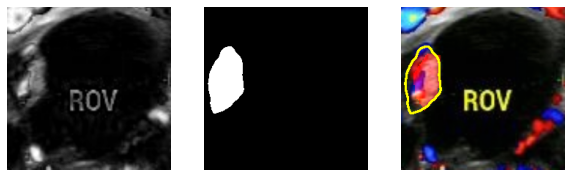

652/653,test_loss:0.0798

In [13]:
test_loss,metric = test(te_dataloader,plot=True)
